## *Variables Générales et Imports*

In [183]:
import urllib.request
import os
import json
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.cluster import KMeans
from PIL import Image

DATA_JSON_PATH = "data.json"
USERS_JSON_PATH = "users.json"

IMAGE_DATATYPES = ["label","date","model","colors","orientation","taille","tags"]
USERS_PREFSTYPES = ["id","colors","orientation","sizes","tags","imagesLiked","colorsDistribution"]
IMAGE_SIZES = ["Grande","Moyenne","Petite","Vignette"]

# Implémentation du Système de Recommandation

## Collecte de données

In [184]:
def clearImages():
    #Supression Des Images
    files = glob.glob('./images/*')
    for f in files:
        os.remove(f)


def CollecteDesImages(queryLimit : str):
    # Récupération de la Query
    url = "https://query.wikidata.org/sparql?query=SELECT%20%3Fitem%20%3FitemLabel%20%3Fimage%0AWHERE%0A%7B%0A%3Fitem%20wdt%3AP31%20wd%3AQ144%20.%0A%3Fitem%20wdt%3AP18%20%3Fimage%0ASERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22%5BAUTO_LANGUAGE%5D%2Cen%22%20%7D%0A%7D%0ALIMIT%20"+str(queryLimit)+"&format=json"
    response = urllib.request.urlopen(url)
    responseJSON  = json.load(response)

    # Création de la dataframe
    columns   = ["label","format","link","path"]
    dataArray = []
    for i, data in enumerate(responseJSON["results"]["bindings"]):
        link = data["image"]["value"]
        label = data["itemLabel"]["value"]
        format = str(link).split(".")[-1]
        path = "./images/" + str(i) +"."+ format
        dataArray.append([label,format,link,path])

    dataframe = pd.DataFrame(dataArray, columns= columns)

    clearImages()

    sizes = []
    # Telechargement des images
    length = len(dataframe.index)
    for i in range(length):
        link = dataframe._get_value(i,'link')
        path = dataframe._get_value(i,'path')
        urllib.request.urlretrieve(link, path)

        img = Image.open(path)
        sizes.append(np.array(img.size))
        img.close()

    dataframe["résolution"] = sizes

    # Création du fichier JSON 
    file = open(DATA_JSON_PATH, "w") 
    file.write(dataframe.to_json())
    file.close()


def RecuperationMetadonneesEXIF():
    dataframe = pd.read_json(DATA_JSON_PATH)

    tags = ["label","date","model"]
    tagsWantedEXIF = [306,272]
    dataEXIF = []
        
    length = len(dataframe.index)
    for i in range(length):
        path = dataframe._get_value(i,'path')
            
        image = Image.open(path)
        exif = image.getexif()

            

        array = [dataframe._get_value(i,'label')]
        for tag in tagsWantedEXIF:
            array.append(exif.get(tag))
        dataEXIF.append(array)
        
    dataframeEXIF = pd.DataFrame(dataEXIF, columns=tags)
    for c in dataframeEXIF.columns :
        dataframe[c] = dataframeEXIF[c]
            
    file = open(DATA_JSON_PATH, "w")
    file.write(dataframe.to_json())
    file.close()

def getDataDataFrame():
    return pd.read_json(DATA_JSON_PATH)



def CollecteDesDonnees(queryLimit : str):
    CollecteDesImages(queryLimit)
    RecuperationMetadonneesEXIF()






## Étiquetage et annotation

In [185]:
def CalculerCouleursPredominantes(Ndiv, Res):
    Ndiv = 3
    Res = 100

    dataframe = pd.read_json(DATA_JSON_PATH)

    colors = []
    distributions = []

    for path in dataframe.path:
        img = Image.open(path).convert("RGB")
        imgArray = np.array(img.getdata())[::Res]
        img.close()
        imgDataframe = pd.DataFrame(imgArray, columns=["red","green","blue"])

        model=KMeans(n_clusters= Ndiv, n_init='auto')
        model.fit(imgDataframe)

        distribution = []
        total = len(list(model.labels_))
        for i in range(Ndiv):
            distribution.append(list(model.labels_).count(i)/total)
        distributions.append(distribution)

        meansList = (np.floor(model.cluster_centers_)).tolist()

        colors.append(meansList)

    dataframe["colors"] = colors
    dataframe["colorsDistribution"] = distributions

    # Création du fichier JSON 
    colorTable = open(DATA_JSON_PATH, "w")
    colorTable.write(dataframe.to_json())
    colorTable.close()


def ImageCouleursPredominantesAff(imageIndex):
    dataDataFrame = pd.read_json()
    colors = np.array(dataDataFrame["colors"][imageIndex])/255
    distribution = np.array(dataDataFrame["colorsDistribution"][0])*100

    fig = plt.figure()
    ax = fig.add_subplot()

    ax.pie(distribution, colors = colors)


def CalculerOrientationEtTaille():
    dataframe = pd.read_json(DATA_JSON_PATH)
    orientations = []
    tailles = []
    for taille in dataframe["résolution"]:
        # Orientation
        if taille[0] > taille[1]:
            orientations.append("Paysage")
        else:
            orientations.append("Portrait")
        
        nbrPixel = taille[0] * taille[1]
    
        if   nbrPixel >= 1920*1080:
            tailles.append("Grande")
        elif nbrPixel >= 1280*720:
            tailles.append("Moyenne")
        elif nbrPixel >= 720*480:
            tailles.append("Petite")
        else :
            tailles.append("Vignette")
        

    dataframe["orientation"] = orientations
    dataframe["taille"] = tailles

    # Création du fichier JSON 
    colorTable = open(DATA_JSON_PATH, "w")
    colorTable.write(dataframe.to_json())
    colorTable.close()


def placeHolder():
    dataframe = pd.read_json(DATA_JSON_PATH)
    dataframe["tags"] = [['dog'] for i in range(len(dataframe["label"]))]

    colorTable = open(DATA_JSON_PATH, "w")
    colorTable.write(dataframe.to_json())
    colorTable.close()


def EtiquetageEtAnnotation():
    CalculerCouleursPredominantes(3,100)
    CalculerOrientationEtTaille()
    placeHolder()



## Analyse des données

In [186]:
def getUserDataFrame():
    return pd.read_json(USERS_JSON_PATH)

def createUser(userId):
    columns = USERS_PREFSTYPES
    row = [[userId,[],None,[],[],[],[]]]
    newData = pd.DataFrame(row, columns= columns)

    try :
        userDataFrame = getUserDataFrame()
    except FileNotFoundError :
        userDataFrame = resetUsersDataFrame()
        
    if not (userId in list(userDataFrame["id"])):
        userDataFrameChanged = pd.concat([userDataFrame,newData],ignore_index=True)
        saveUserDataFrame(userDataFrameChanged)
    else :
        print("User already exist")

def deleteUser(userId):
    userDataFrame = getUserDataFrame()

    if userId in list(userDataFrame["id"]) :
        if userId in list(userDataFrame["id"]):
            index = list(userDataFrame["id"]).index(userId)
            userDataFrame = userDataFrame.drop([index])
        saveUserDataFrame(userDataFrame)

def resetUsersDataFrame():
    columns = USERS_PREFSTYPES
    userDataFrame = pd.DataFrame(columns = columns)
    saveUserDataFrame(userDataFrame)
    return userDataFrame

def getUserPreferences(userId):
    userDataFrame = getUserDataFrame()
    prefs = []
    if userId in list(userDataFrame["id"]):
        index = list(userDataFrame["id"]).index(userId)
        prefs = userDataFrame.iloc[index]
    return(prefs)

def saveUserDataFrame(userDataFrame):
    usersJSON = open(USERS_JSON_PATH, "w")
    usersJSON.write(userDataFrame.to_json())
    usersJSON.close()

def ajouterImagesUserManuellement(userId):
    dataDataFrame = pd.read_json(DATA_JSON_PATH)
    userDataFrame = pd.read_json(USERS_JSON_PATH)

    i = random.randint(0,len(dataDataFrame["label"])-1)
    while i in userDataFrame["imagesLiked"][list(userDataFrame["id"]).index(userId)] :
        i = random.randint(0,len(dataDataFrame["label"])-1)

    img = Image.open(dataDataFrame["path"][i]).convert('RGB')
    img.show()

    invalid = True
    while invalid:
        ans = input("Do you like this image ? [y/n]").capitalize()
        invalid = ans not in ["Y","N"]
    liked = ans == "Y"  
    if liked :
        (userDataFrame["imagesLiked"][list(userDataFrame["id"]).index(userId)]).append(i)

    saveUserDataFrame(userDataFrame)
    userDataFrame

def ajouterImagesUserAuto(userId, nbrImages):
    dataDataFrame = pd.read_json(DATA_JSON_PATH)
    userDataFrame = pd.read_json(USERS_JSON_PATH)
    userIndex = list(userDataFrame["id"]).index(userId)

    imagesLikedBefore = list(userDataFrame["imagesLiked"][userIndex])

    imagesIndex = []

    if (restrictedNbr := len(list(dataDataFrame['label'])) -  len(imagesLikedBefore)) < nbrImages:
        nbrImages = restrictedNbr

    for n in range(nbrImages):
        i = random.randint(0,len(dataDataFrame["label"])-1)
        while i in (userDataFrame["imagesLiked"][userIndex]) or i in imagesIndex :
            i = random.randint(0,len(dataDataFrame["label"])-1)
        imagesIndex.append(i)

    userDataFrame["imagesLiked"][userIndex] += imagesIndex

    saveUserDataFrame(userDataFrame)

    imagesLikedNow = list(userDataFrame["imagesLiked"][userIndex])
    print(f'Images likées : {[image for image in imagesLikedNow if image not in imagesLikedBefore]}')

def deleteUserLikedImages(userId):
    userDataFrame = pd.read_json(USERS_JSON_PATH)
    userIndex = list(userDataFrame["id"]).index(userId)
    userDataFrame["imagesLiked"][userIndex] = []
    saveUserDataFrame(userDataFrame)

def CalculPreferencesUser():
    dataDataFrame = pd.read_json(DATA_JSON_PATH)
    userDataFrame = pd.read_json(USERS_JSON_PATH)

    for userId in list(userDataFrame["id"]):
        index = list(userDataFrame["id"]).index(userId)
        imagesLikedindex = list(userDataFrame["imagesLiked"][index])

        colors = []
        orientations = []
        sizes = []
        tags = []

        if imagesLikedindex != []:

            # Collecte des Informations des Images Likées
            for i in imagesLikedindex:
                colors += list(dataDataFrame["colors"])[i]
                orientations += list(dataDataFrame["orientation"])[i]
                sizes.append(list(dataDataFrame["taille"])[i])
                tags += list(dataDataFrame["tags"])[i]

            # Couleurs préférées (Les 5 noyaux du Kmeans sur les couleurs des images likées)
            colorsArray =np.array(colors)
            imgDataframe = pd.DataFrame(colorsArray, columns=["red","green","blue"])
            model=KMeans(n_clusters= 5, n_init='auto')
            model.fit(imgDataframe)

            distribution = []
            total = len(list(model.labels_))
            for i in range(len(model.cluster_centers_)):
                distribution.append(list(model.labels_).count(i)/total)

            userDataFrame["colors"][index] = list(np.floor(model.cluster_centers_))
            userDataFrame["colorsDistribution"][index] = distribution


            # Orientation préféré (Celle majoritaire)
            if orientations.count("Paysage") > len(orientations)//2 :
                userDataFrame["orientation"][index] = "Paysage"
            else:
                userDataFrame["orientation"][index] = "Portrait"

            # Tailles préférées (les 2 majoritairement représentées)
            t1 = 0
            t2 = 0
            for i,taille in enumerate(IMAGE_SIZES) :
                if (c := sizes.count(taille)) > t1 :
                    t1 = i
                elif (c := sizes.count(taille)) > t2 and c != t1:
                    t2 = i
            userDataFrame["sizes"][index] = [IMAGE_SIZES[t1],IMAGE_SIZES[t2]]

            # Tags préférées (les 5 majoritairement représentées)
            tagsTreated = []
            tagsCount = []
            for tag in tags :
                if tag in tagsTreated:
                    tagsCount[tagsTreated.index(tag)] += 1
                else:
                    tagsTreated.append(tag)
                    tagsCount.append(1)
            preferredTags = []
            for i in range(5):
                if len(tagsCount)>0:
                    index = tagsCount.index(np.max(tagsCount))
                    preferredTags.append(tagsTreated.pop(index))
                    tagsCount.pop(index)

            userDataFrame["tags"][index] = preferredTags

    saveUserDataFrame(userDataFrame)

def colorsUserAff(userId):
    userDataFrame = pd.read_json(USERS_JSON_PATH)
    index = list(userDataFrame["id"]).index(userId)
    colors = np.array(userDataFrame["colors"][index])/255
    distribution = np.array(userDataFrame["colorsDistribution"][index])*100

    fig = plt.figure()
    ax = fig.add_subplot()

    ax.pie(distribution, colors = colors)


## Visualisation des données

In [187]:
def visualistionDesDonnees(target, category):
     dataDataFrame = pd.read_json(DATA_JSON_PATH)
     userDataFrame = pd.read_json(USERS_JSON_PATH)

     df = dataDataFrame
     userIds = list(userDataFrame["id"])
     target = ""
     if target in userIds:
          df = pd.DataFrame()
          for imageIndex in userDataFrame["imagesLiked"]:
               df = pd.concat([df, dataDataFrame.iloc[imageIndex]])

     distribution = []

     for item in df[category]:
          if (item != None) and (item != []):
               if category == 'date':
                         distribution.append(str(item).split(':')[0])
               else:
                    distribution.append(str(item))
          else :
               distribution.append("Indéterminé")

     plt.hist(distribution, rwidth = 0.8, color = "orange")

def caracteristiquesDesCouleurs():
     dataDataFrame = pd.read_json(DATA_JSON_PATH)
     category = "colors"
     distribution = []

     for item in dataDataFrame[category]:
          if (item != None) and (item != []):
               distribution += item
          else :
               distribution.append("Indéterminé")
     distribution = np.array(distribution)

     r = [c[0]/255  for c in distribution]
     g = [c[1]/255  for c in distribution]
     b = [c[2]/255  for c in distribution]
     c = distribution/255

     fig = plt.figure()
     ax = fig.add_subplot(projection='3d')
     ax.scatter(r,g,b,c = c)

## Système de Recommandation

In [202]:
def recommand():
    dataDataFrame = pd.read_json(DATA_JSON_PATH)
    userDataFrame = pd.read_json(USERS_JSON_PATH)

    userId = ""
    while not userId in list(userDataFrame["id"]) :
        userId = input("user Id :")
    userPrefs = getUserPreferences(userId)
    recommandation = pd.DataFrame()

    if list(userPrefs) != [] :
        
        if userPrefs['sizes'] != [] :
            for size in userPrefs['sizes']:
                recommandation = pd.concat([recommandation,dataDataFrame.loc[dataDataFrame['taille'] == size]])

        if userPrefs['orientation'] != None :
            recommandation = recommandation.loc[recommandation['orientation'] == userPrefs['orientation']]
        
    return recommandation.sort_index()


# Tests

In [189]:
#CollecteDesDonnees(queryLimit= 10)

In [190]:
#EtiquetageEtAnnotation()

In [191]:
#getDataDataFrame()

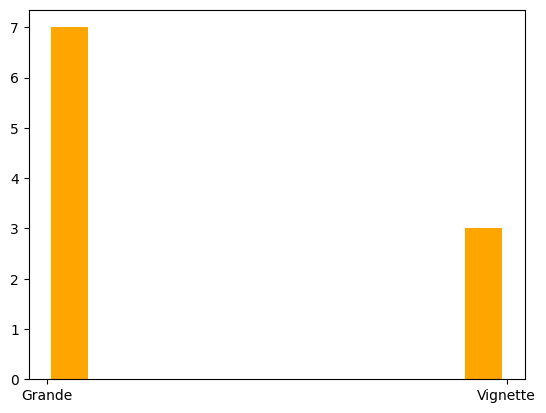

In [192]:
visualistionDesDonnees(target= "all", category= "taille")

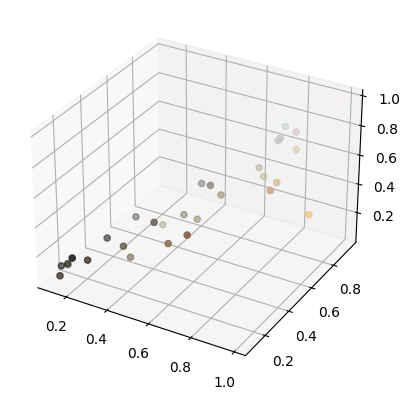

In [193]:
caracteristiquesDesCouleurs()

In [194]:
resetUsersDataFrame()

,id,colors,orientation,sizes,tags,imagesLiked,colorsDistribution


In [ ]:
userId = 'john'
createUser(userId)
ajouterImagesUserAuto(userId, nbrImages=5)

In [ ]:
CalculPreferencesUser()

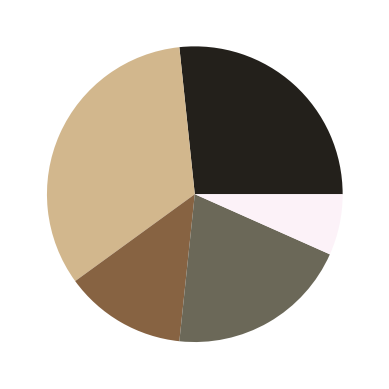

In [197]:
colorsUserAff("john")

In [198]:
getUserDataFrame()

,id,colors,orientation,sizes,tags,imagesLiked,colorsDistribution
0,john,"[[35.0, 32.0, 27.0], [210.0, 183.0, 141.0], [1...",Portrait,"[Vignette, Grande]",[dog],"[4, 0, 5, 8, 6]","[0.2666666667, 0.33333333330000003, 0.13333333..."


In [203]:
recommand()

,label,format,link,path,résolution,date,model,colors,colorsDistribution,orientation,taille,tags
0,Negro Matapacos,jpg,http://commons.wikimedia.org/wiki/Special:File...,./images/0.jpg,"[3801, 5701]",2020:03:03 23:00:15,NIKON D5200,"[[109.0, 94.0, 89.0], [187.0, 181.0, 153.0], [...","[0.29240502820000003, 0.2259201831, 0.4816747886]",Portrait,Grande,[dog]
1,Néro,jpg,http://commons.wikimedia.org/wiki/Special:File...,./images/1.jpg,"[480, 640]",None,None,"[[90.0, 76.0, 33.0], [192.0, 182.0, 139.0], [1...","[0.38802083330000003, 0.3736979167, 0.23828125]",Portrait,Vignette,[dog]
2,Thunder the Dog,jpeg,http://commons.wikimedia.org/wiki/Special:File...,./images/2.jpeg,"[263, 388]",2020:03:17 11:30:18,None,"[[160.0, 147.0, 119.0], [84.0, 72.0, 53.0], [2...","[0.3046033301, 0.20959843290000002, 0.485798237]",Portrait,Vignette,[dog]
5,Dylan,jpg,http://commons.wikimedia.org/wiki/Special:File...,./images/5.jpg,"[235, 380]",None,None,"[[129.0, 122.0, 90.0], [35.0, 38.0, 27.0], [20...","[0.38969764840000004, 0.3381858903, 0.2721164614]",Portrait,Vignette,[dog]
7,Kratu,jpg,http://commons.wikimedia.org/wiki/Special:File...,./images/7.jpg,"[1613, 1613]",2020:11:29 14:18:27,SM-A520F,"[[216.0, 208.0, 207.0], [67.0, 67.0, 64.0], [1...","[0.24413867320000002, 0.42078561000000003, 0.3...",Portrait,Grande,[dog]
8,Peter the Great,jpg,http://commons.wikimedia.org/wiki/Special:File...,./images/8.jpg,"[1280, 1851]",None,None,"[[85.0, 96.0, 87.0], [252.0, 242.0, 248.0], [2...","[0.5054657494, 0.17536825220000002, 0.3191659984]",Portrait,Grande,[dog]
